<a href="https://colab.research.google.com/github/Yohk2291/MachineLearning/blob/master/image_classification/1_2_transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Yohk2291/MachineLearning.git
%cd MachineLearning/
%cd image_classification/

Cloning into 'MachineLearning'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/MachineLearning/image_classification/MachineLearning/image_classification/MachineLearning/image_classification/MachineLearning
/content/MachineLearning/image_classification/MachineLearning/image_classification/MachineLearning/image_classification/MachineLearning/image_classification


In [0]:
import os
import urllib.request
import zipfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [0]:
# アリとハチの画像データをダウンロードし解凍
# PyTorchのチュートリアルで用意されているものです
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
save_path = os.path.join(data_dir, "hymenoptera_data.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # ZIPファイルを読み込み
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

    # ZIPファイルを消去
    os.remove(save_path)

## 各種パッケージのインポート

In [0]:
import glob
import os.path as osp
import random
import numpy as np
import json 
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [0]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [0]:
# 計算結果を完全に再現する場合に設定（不要時コメントアウト）
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
print("PyTorch Version", torch.__version__)
print("Torchvision Version", torchvision.__version__)

PyTorch Version 1.1.0
Torchvision Version 0.3.0


## Datasetの作成

In [0]:
# 訓練時と推論時で異なる前処理を実行
class ImageTransform():
  def __init__(self, resize, mean, std):
    self.data_transform = {
        'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), # 0.5-1.0の間で画像を拡大・縮小
                transforms.RandomHorizontalFlip(), # 画像の左右を50%の確率で反転
                transforms.ToTensor(), # テンソルに変換
                transforms.Normalize(mean, std) # 標準化
                ]),
        'val' : transforms.Compose([
               transforms.Resize(resize), # 短辺の長さがresizeの大きさになる
               transforms.CenterCrop(resize), # 画像の中心をresize * resizeで切り取る
               transforms.ToTensor(), # テンソルに変換
               transforms.Normalize(mean, std) # 標準化
               ])
    }
    
  def __call__(self, img, phase='train'):
    return self.data_transform[phase](img) # phaseでtrain or val を指定

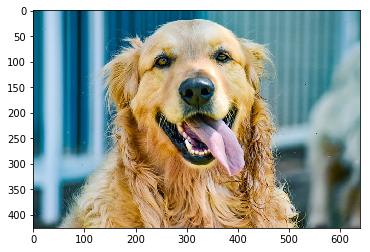

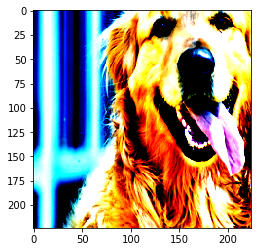

In [0]:
# 上記クラスの動作確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

# (C, H, W) -> (H, W, C)に変換
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
# 0-1に値を制限
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [0]:
# アリとハチの画像へのファイルパスのリストを作成する


def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。

    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する

    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # ここに格納する

    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/bees/2765347790_da6cf6cb40.jpg',
 './data/hymenoptera_data/train/bees/2397446847_04ef3cd3e1.jpg',
 './data/hymenoptera_data/train/bees/522104315_5d3cb2758e.jpg',
 './data/hymenoptera_data/train/bees/2445215254_51698ff797.jpg',
 './data/hymenoptera_data/train/bees/537309131_532bfa59ea.jpg',
 './data/hymenoptera_data/train/bees/969455125_58c797ef17.jpg',
 './data/hymenoptera_data/train/bees/2467959963_a7831e9ff0.jpg',
 './data/hymenoptera_data/train/bees/2601176055_8464e6aa71.jpg',
 './data/hymenoptera_data/train/bees/2645107662_b73a8595cc.jpg',
 './data/hymenoptera_data/train/bees/1093831624_fb5fbe2308.jpg',
 './data/hymenoptera_data/train/bees/16838648_415acd9e3f.jpg',
 './data/hymenoptera_data/train/bees/342758693_c56b89b6b6.jpg',
 './data/hymenoptera_data/train/bees/2625499656_e3415e374d.jpg',
 './data/hymenoptera_data/train/bees/95238259_98470c5b10.jpg',
 './data/hymenoptera_data/train/bees/2364597044_3c3e3fc391.jpg',
 './data/hymenoptera_data/train/b

In [0]:
class HymenopteraDataset(data.Dataset):
  """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

  def __init__(self, file_list, transform=None, phase='train'):
    self.file_list = file_list  # ファイルパスのリスト
    self.transform = transform  # 前処理クラスのインスタンス
    self.phase = phase  # train or valの指定

  def __len__(self):
    '''画像の枚数を返す'''
    return len(self.file_list)

  def __getitem__(self, index):
    '''前処理をした画像のTensor形式のデータとラベルを取得'''
    # index番目の画像をロード
    img_path = self.file_list[index]
    img = Image.open(img_path)  # [高さ][幅][色RGB]

    # 画像の前処理を実施
    img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])

    # 画像のラベルをファイル名から抜き出す
    if self.phase == "train":
      label = img_path[30:34]
    elif self.phase == "val":
      label = img_path[28:32]

    # ラベルを数値に変更する
    if label == "ants":
      label = 0
    elif label == "bees":
      label = 1

    return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


## DataLoaderを作成

In [0]:
# ミニバッチのサイズ
batch_size = 32

# DataLoaderの作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


# 動作確認
batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(
    batch_iterator)

print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 1, 0])


## ネットワークモデルの作成

In [0]:
# 学習済みVGG-16をロード
use_pretrained = True #学習済みパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
print(net)

# VGG-16の最後の出力層の出力ユニットをアリとハチの２つに付け替える 
net.classifier[6] = nn.Linear(in_features=4096, out_features=2) # out_features: 1000 -> 2

# 訓練モードに設定
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

## 損失関数を定義

In [0]:
# クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()

## 最適化手法の設定

In [0]:
# 転移学習で学習させるパラメータを格納
params_to_update = []

# 学習させるパラメータ（VGG-16の最後の出力層の重み、バイアス）
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は変化させない
for name, param in net.named_parameters():
  if name in update_param_names:
    param.requires_grad = True
    params_to_update.append(param)
    print(name)
  else:
    param.requires_grad = False

print("-" * 80)
print(params_to_update)

classifier.6.weight
classifier.6.bias
--------------------------------------------------------------------------------
[Parameter containing:
tensor([[ 0.0117,  0.0116,  0.0082,  ..., -0.0072,  0.0059, -0.0065],
        [-0.0071, -0.0131, -0.0117,  ..., -0.0079, -0.0070,  0.0085]],
       requires_grad=True), Parameter containing:
tensor([-0.0087,  0.0008], requires_grad=True)]


In [0]:
# 最適化手法の設定(MomentumSGD)
optimizer = optim.SGD(params=params_to_update, lr=0.01, momentum=0.9)

## 学習・検証

In [0]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  # epochのループ
  for epoch in range(num_epochs):
    print('Epoch{}/{}'.format(epoch+1, num_epochs))
    print('-'*80)

    # epoch毎の学習と検証のループ
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train() # 訓練モードにする
      else:
        net.eval() # 検証モードにする

      epoch_loss = 0.0 # epochの損失和
      epoch_corrects = 0 # epochの正解数

      # 学習前の性能を確かめるため、epoch=0での訓練は省略
      if (epoch == 0) and (phase == 'train'):
        continue
      
      # dataloaderからミニバッチを取り出す
      for inputs, labels in tqdm(dataloaders_dict[phase]):

        # optimizer を初期化
        optimizer.zero_grad()

        # 順伝播
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          # 訓練時は逆伝播も
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # lossの合計を更新
          epoch_loss += loss.item() * inputs.size(0)
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

      # epoch毎のlossと正解率を出力
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

      print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [0]:
# 学習・検証を実行
num_epochs = 5
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch1/5
--------------------------------------------------------------------------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.8070, Acc: 0.3595
Epoch2/5
--------------------------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.3184, Acc: 0.8642


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1598, Acc: 0.9542
Epoch3/5
--------------------------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0946, Acc: 0.9671


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1169, Acc: 0.9673
Epoch4/5
--------------------------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0687, Acc: 0.9753


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0879, Acc: 0.9739
Epoch5/5
--------------------------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.0505, Acc: 0.9877


100%|██████████| 5/5 [00:57<00:00, 11.29s/it]

val Loss: 0.1197, Acc: 0.9608
